#### GISC 425 T1 2020
# **LAB ASSIGNMENT 1**

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as pyplot
import geopandas

There's quite a lot to think about here, *but not actually very much code to write*. For submission instructions see the last cells of the notebook. But before getting to that, there is a fair bit to work through and chew on.

# Hexbins and map projection
This assignment takes a look at the implications of map projection for a popular visualization technique *hexbinning* when applied to geographical data over large geographical extents.

The exercise is inspired by this recent paper, which deserves an award for its great title, if nothing else

+ Battersby, S. E., D. “daan” Strebe, and M. P. Finn. 2016. [Shapes on a plane: evaluating the impact of projection distortion on spatial binning](http://www.tandfonline.com/doi/full/10.1080/15230406.2016.1180263). Cartography and Geographic Information Science :1–12.

The essential point of the paper is that the assumption that hexbinning is a good way to visualize density depends on how much area distortion is induced by the map projections in use.

To explore this we work with a global dataset of earthquake incidents, and also develop some code (I've done most of this) to make hexbin maps using `geopandas`.

## World earthquakes
Before getting started, let's load the dataset we will work with.

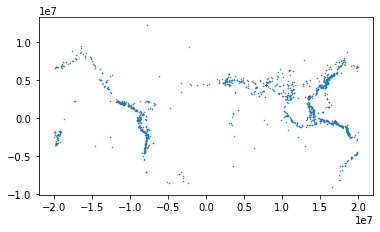

In [2]:
quakes = geopandas.read_file('earthquakes-webmerc.geojson')
quakes.plot(markersize=0.25)

These data were obtained from [National Centers for Environmental Information at NOAA](https://www.ngdc.noaa.gov/nndc/struts/form?t=101650&s=1&d=1), and include all earthquakes of intensity 6.8 or greater since 1900.  I cleaned up the raw data a little to remove columns we aren't much interested in, and also passed them through [QGIS](http://www.qgis.org/en/site/) to produce the GeoJSON format file from the raw CSV provided.

We can put these on a base map of the world, just so we are sure where we are. `geopandas` provides a built in world map dataset. We don't need Antarctica, and we need it in the same projection as the earthquakes.

In [3]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# get rid of Antarctica
world = world[world.continent != 'Antarctica']
# reproject to match the quakes data
world = world.to_crs(quakes.crs)

Now map them.

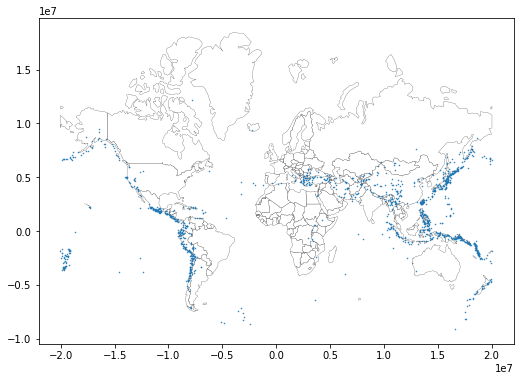

In [4]:
fig = pyplot.figure(figsize=(10,6))
base = fig.add_subplot(111)
world.plot(ax=base, facecolor='w', edgecolor='k', linewidth=0.2)
quakes.plot(ax=base, markersize=0.25)

At this point, you may already smell a rat (hint: what projection are these data in?)

### Narrowing the focus
Anyhow...

We will look only at quakes in the 'ring of fire' around the Pacific. This is more or less between 60N and 60S and between 110E and 70W. That turns out to be easy to write, but a bit trickier to handle in a map. Here's how the selection works: 

In [5]:
# first do the latitude limits
q = quakes[(quakes.LATITUDE > -60) & (quakes.LATITUDE < 60)] # between 60-60
# next the longitude limits -- note that here we use an or condition |
q = q[(q.LONGITUDE > 110) | (q.LONGITUDE < -70)] # between 110 east to 70 west 

The `quakes.LONGITUDE` and `quakes.LATITUDE` comparison tests are combined using logical AND `&` and logical OR `|` symbols to pick out the quakes that are in the region of interest. these are a bit different than the `and` and `or` boolean operations we have seen in Python more generally because of how `geopandas` works.

### Dealing with the dateline
Mapping the remaining data in the `q` dataset we get:

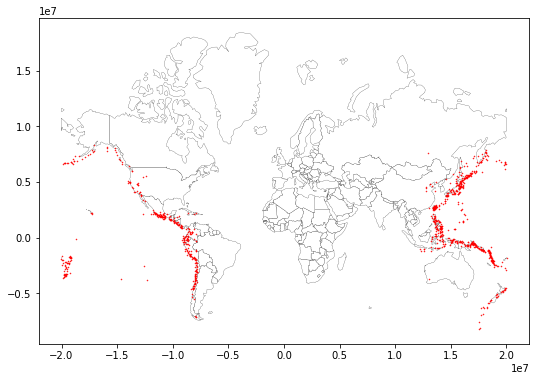

In [6]:
fig = pyplot.figure(figsize=(10,6))
base = fig.add_subplot(111)
world.plot(ax=base, facecolor='w', edgecolor='k', linewidth=0.2)
q.plot(ax=base, color='r', markersize=0.25, figsize=(12,6))

The problem is that as far as our projection is concerned, the world ends at the dateline (this happens a lot with data in the Pacific). Looking on [projectionwizard.org](https://projectionwizard.org) I found this proj4 string, which might help at least a bit

    +proj=laea +lat_0=0 +lon_0=-167.5
    
Let's see what happens if we project our datasets and make a new map.

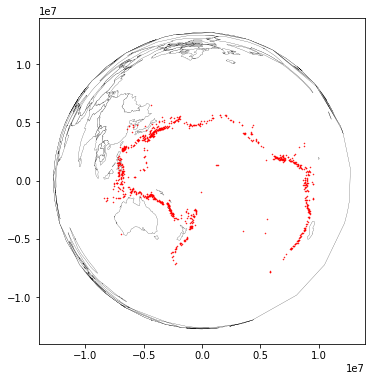

In [7]:
## Do the projections
worldp = world.to_crs('+proj=laea +lat_0=0 +lon_0=-167.5')
qp = q.to_crs('+proj=laea +lat_0=7.5 +lon_0=-167.5')

fig = pyplot.figure(figsize=(10,6))
base = fig.add_subplot(111)
worldp.plot(ax=base, facecolor='w', edgecolor='k', linewidth=0.2)
qp.plot(ax=base, color='r', markersize=0.25)

### Plan B

Hmmm. Not too bad, but you know what... this is going to be too difficult. \[It's still useful to take something away from the failure of plan A... the world being a sphere and maps being flat has more than one effect on how we deal with spatial data\]

Anyway, plan B is that we'll only look at the western half of the ring of fire, that is on the New Zealand side of the dateline, or in other words, places where the longitude is a positive number:

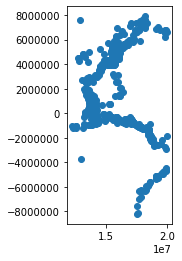

In [8]:
q = q[q.LONGITUDE > 0]

q.plot()

To make a nice map we need to **clip** the world to the extent of the quakes, we can do this by making an extent polygon from the earthquakes dataset and clipping the world dataset to it.

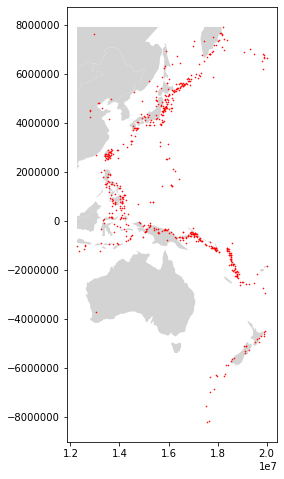

In [9]:
# Make a polygon by constructing an envelope from the union of all the geometries in the q dataset
extent = q.unary_union.envelope
# Make that into a GeoDataFrame
q_extent = geopandas.GeoDataFrame(geometry=geopandas.GeoSeries(extent))
# Make sure it has the right CRS
q_extent.crs = q.crs

# Now make a new world dataset clipped to this extent
w = geopandas.overlay(world, q_extent, 'intersection')

base = w.plot(facecolor='lightgrey', figsize=(4,8))
q.plot(ax=base, color='r', markersize=.35)

At last! While I don't expect you to have been able to write the code above, it is worth spending some time with it (now and later) to make sure you at least have some idea what is happening. Later in the semester we will explore using geopandas as a GIS and will take a closer look at the geometric operations it provides for manipulating spatial data.

## Hexbin maps
The best way to appreciate what hexbins are is to try them. `pyplot` has a built in hexbin function. Give it a try by running the cell below.

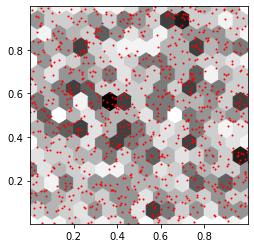

In [10]:
import random
# make 500 random x,y coordinates
x = [random.random() for __ in range(1000)]
y = [random.random() for __ in range(1000)]

fig = pyplot.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal') # this makes it look a bit nicer
# plot hexbins
pyplot.hexbin(x, y, gridsize=15, cmap='Greys')
# put the points on top for reference, note r. specifies points, not lines!
pyplot.plot(x, y, 'r.', markersize=2)

The idea is that the colored in plot makes it easier to identify 'hotspots' or concentrations in the data.  It is particularly useful with large number of points (try changing the number of points in the cell above).

Now, this is fine as far as it goes, but is not ideal if our $(x,y)$ coordinates are actually geographical coordinates, because lest we forget *the Earth is not flat*. 

The built in hexbin plot doesn't treat the two coordinates as equal which is why I added the line `ax.set_aspect('equal')`.  But a more insidious difficulty is that geographic coordinates affect the *area* of the hexagons, so that the supposedly unbiased picture of the variations in density of points across the 'map' may not be unbiased at all.

### A geographic hexbin map
So... I've written a small 'wrapper' function for the hexbin function (below) which we can use instead.

Take a look in the cell below, before running it. 

You **absolutely don't need to understand all that is happening here in detail**, because you are just going to use the `get_hexbin_data()` function. I've split things into three functions, as follows.

#### `get_hexgrid_size_and_extent()` 
This function determines the number of hexes in the x and y directions and also the x and y coordinate range of the plot.

In [11]:
import shapely # needed for geometry manipulations to make the hexes GeoSeries

# Returns a suitable grid dimension and extent for hexbinning
# based on an input points GeoDataframe. nx specifies the
# desired number of hexagons in the x direction. A one hex
# wide 'buffer' is included.
def get_hexgridsize_and_extent(pts, nx=15):
    # we need this later
    sqrt3 = 3 ** 0.5
    
    # see http://geopandas.org/reference.html#geopandas.GeoSeries.total_bounds
    x_min, y_min, x_max, y_max = pts.total_bounds
    x_range = x_max - x_min
    y_range = y_max - y_min

    # use this information to give us a little more room - a buffer
    x_buffer = x_range / (nx * 2)
    y_buffer = x_buffer * sqrt3 # y needs more because hexes are taller than they are wide
    x_min = x_min - x_buffer
    x_max = x_max + x_buffer
    y_min = y_min - y_buffer
    y_max = y_max + y_buffer
    
    # the hexbin function needs a grid and extent
    grid_dimensions = (nx, int(nx * y_range / x_range / sqrt3))
    pt_extent = (x_min, x_max, y_min, y_max)
    
    return grid_dimensions, pt_extent

#### `get_x_and_y()` 
This function gets simple lists of x and y coordinates from the provided points `GeoDataFrame`

In [12]:
# Returns simple lists of the x and y coordinates
# of a supplied points GeoDataframe
def get_x_and_y(pts):
    x = [p.x for p in pts.geometry]
    y = [p.y for p in pts.geometry]
    return x, y

#### `get_hexbin_data()`
This one does the work and returns the hexbins as a `GeoDataFrame`

In [13]:
# makes a hexbin GeoDataFrame and also an 'all hexbins' GeoDataFrame
# from supplied pt layer with the specified nx number of hexes across
# the tricky part here is extracting hexagons from the PathCollection
# returned by pyplot.hexbin()
def get_hexbin_data(pt_layer, nx=15, show=True):
    grid_dim, pt_extent = get_hexgridsize_and_extent(pt_layer, nx)
    x, y = get_x_and_y(pt_layer)

    # use pyplot.hexbin to perform the analysis
    # retaining the output, details of which are available at
    # http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hexbin
    hb = pyplot.hexbin(x, y, extent=pt_extent, gridsize=grid_dim, visible=show)
    
    # retrieve the base hexagon as a shapely Polygon from the hexbin results
    base_hex = shapely.geometry.polygon.Polygon([xy[0] for xy in hb.get_paths()[0].iter_segments()])
    # make the array of hexbins by iterating over the 'offsets'
    hex_shapes = [shapely.affinity.translate(base_hex, xoff=dx, yoff=dy) for (dx, dy) in hb.get_offsets()]
    # now make a geopandas GeoDataFrame with these as its geometry column
    hexes = geopandas.GeoDataFrame(geometry=geopandas.GeoSeries(hex_shapes))
    # also add the counts from the hexbin results
    hexes['n'] = list(hb.get_array())
    # set the CRS
    hexes.crs = pt_layer.crs
    
    # return the GeoDataFrame
    return hexes

### Using `get_hexbin_data()`
So now let's use this function.

Here, you need to pay close attention, because you will be asked to do something similar yourself.

First, run the function to make hexbins, retaining both the result as `hexbins`.

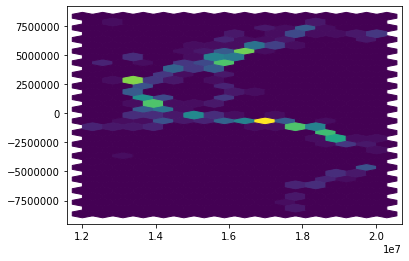

In [14]:
hexbins = get_hexbin_data(q)

Don't worry for now about the goofy shape of the output, which is the raw result from the `pyplot.hexbin()` plot.

Next we use a `geopandas` overlay operation to make a basemap we can use in a final map.

In [15]:
# overlay the world data with the hexbins 
# this will clip it to the extent we need
w = geopandas.overlay(world, hexbins, 'intersection')

And now we can build our map.

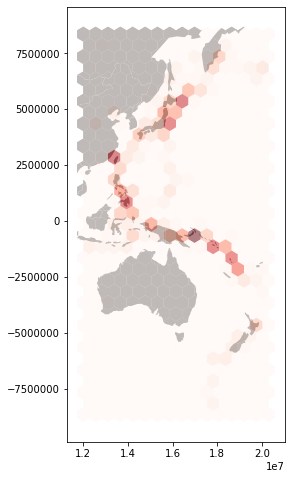

In [16]:
fig = pyplot.figure(figsize=(5,8))
base = fig.add_subplot(111)

# plot the world data
w.plot(ax=base, facecolor='grey')
# plot the hexbins
hexbins.plot(ax=base, column='n', cmap='Reds', alpha=0.5)

Now, we are ready to put everything together and complete the assignment.  

# Assignment instructions
So... here's what you are required to do.

First, **save a new copy of this notebook to work in**. Include your name in the file name, so it will be easy for me to keep track of whose work it is.

Then using an **appropriate equal area projection** (use [this website](http://projectionwizard.org/) to discover the PROJ4 code for suitable projections) make a second hexbin map to go alongside the base one in the code cell below. 

To do this, you'll want to use the `to_crs()` function on the quakes `q` dataset *to make a new projected version*. You will also need to apply the same projection to the `world` dataset to get the basemap right. Make sure you *make a new variable* when you do these transformation, or things will probably get confused (call them something like `q_p` and `world_p`.

When you have successfully made these maps, compare them. Have the apparent hotspots moved? To what do you attribute the movement (if any)? Comment on these or any other aspects (particularly the coding challenges) in the plain text cell below the code cell.

You should complete the code cell below, and also the cell that follows with any commentary.

**When you are finished, save the completed notebook for upload to the dropbox provided on blackboard.**

### Below is the code cell you should work in
You may find it useful to make a duplicate of it before you start.

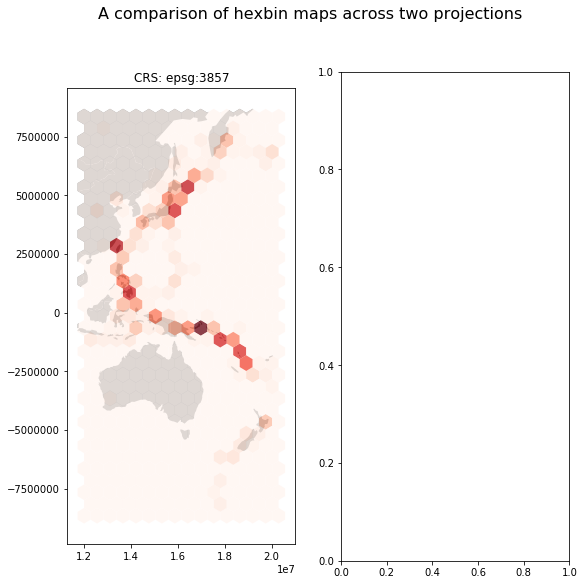

In [17]:
## Make a two panel plot for the two hexbin maps
fig = pyplot.figure(figsize=(9,9)) # you might want to change the size
fig.suptitle("A comparison of hexbin maps across two projections", fontsize=16)

ax = fig.add_subplot(121)
ax.set_title('CRS: ' + str(q.crs))

hexbins = get_hexbin_data(q, show=False) # redo hebin projection
w = geopandas.overlay(world, hexbins, 'intersection')

w.plot(ax=ax, facecolor='grey')
hexbins.plot(ax=ax, column='n', cmap="Reds", alpha=0.75)

## Equal-area hexbins in panel 2
## Find an appropriate equal area projection and
## include it in the code outlined below
ax = fig.add_subplot(122)
# proj = 
# ax.set_title()
# reproject the quakes and world datasets
# and redo the hexbin mapping


**Double-click to edit**

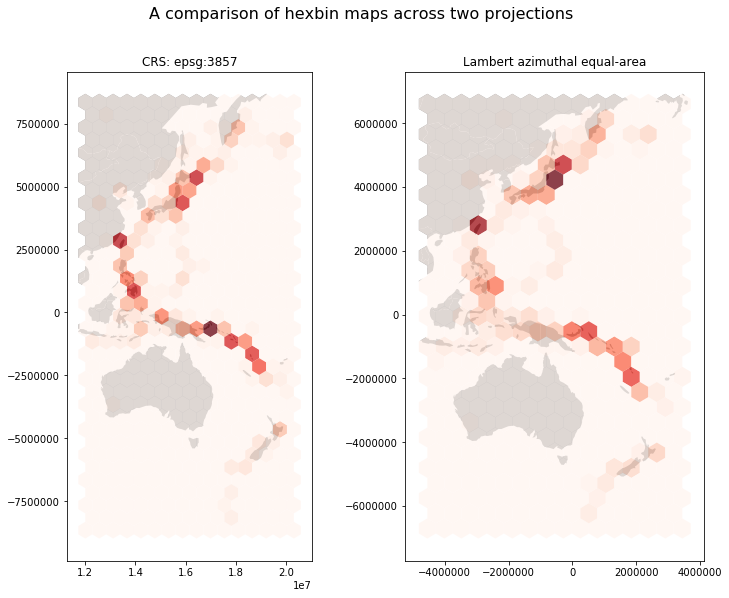

In [18]:
## Make a two panel plot for the two hexbin maps
fig = pyplot.figure(figsize=(12,9)) ## Equal-area hexbins in panel 2 +  changing panel size

fig.suptitle("A comparison of hexbin maps across two projections", fontsize=16)

ax = fig.add_subplot(121)
ax.set_title('CRS: ' + str(q.crs))

hexbins = get_hexbin_data(q, show=False)  
w = geopandas.overlay(world, hexbins, 'intersection')

w.plot(ax=ax, facecolor='grey')
hexbins.plot(ax=ax, column='n', cmap="Reds", alpha=0.75)


## Find an appropriate equal area projection 
proj= '+proj=laea +lon_0=150'# proj =
world_p = world.to_crs(proj)
q_p = q.to_crs(proj)

ax2 = fig.add_subplot(122)
ax2.set_title("Lambert azimuthal equal-area") # ax.set_title()

# 1) reproject the quakes and world datasets and 2) redo the hexbin mapping

hexbins_2 = get_hexbin_data(q_p, show=False)
w_2= geopandas.overlay(world_p, hexbins_2, 'intersection')

w_2.plot(ax=ax2, facecolor='grey')
hexbins_2.plot(ax=ax2, column='n', cmap="Reds", alpha=0.75)

